# Analyzing Lucio's galaxies from Ponos zoom-in simulations

``` 
* PonosQ (the smaller galaxy discussed in Fiacconi et al. 2016)
* PonosV (the larger galaxy)
* PonosSB (the same as PonosV but with a different stellar feedback scheme). 

Each archive contains 50 files. The files correspond to 50 lines of sight. Each file contains a 512x512 2D numpy array that represents the stellar surface density map. The data stored in the array are in units of Msol/kpc^2. The physical extent of the maps is 400 physical kpc, i.e. from -200 to 200 kpc in both x and y. All the data are at z=0.408 and I removed the subhaloes according to the size of their virial/tidal radius.
```
$H_0=70.2 km s^{-1} Mpc^{-1}$

no AGN feedback


In [43]:
import numpy as np
import h5py
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import gridspec
from matplotlib import rc
import matplotlib.pylab as plt

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

import scipy.stats as st

import glob
import os
import pickle
import sys

from astropy.table import Table

sys.path.append('/Users/fardila/Documents/GitHub/HSC_vs_hydro/')
from functions import *

In [76]:
def get_median_profile(isos, pixel_scale, r_bins, quantity = 'intens'):
    """Get the median profiles."""
    
    if quantity == 'intens':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25, 
                                               np.log10(gal[quantity] / (pixel_scale ** 2)),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(r_bins) 
                               for gal in isos]), axis=0)
    if quantity == 'intens_kpc':
        mu = np.nanmedian(np.stack([interp1d((gal['sma_kpc']) ** 0.25, 
                                               np.log10(gal[quantity]),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(r_bins) 
                               for gal in isos]), axis=0)
    elif quantity == 'growth_ori':
        mu = np.nanmedian(np.stack([interp1d((gal['sma_kpc']) ** 0.25, 
                                               np.log10(gal[quantity]),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(r_bins) 
                               for gal in isos]), axis=0)
        
#     elif quantity == 'hsc':
#         mu = np.nanmedian(np.stack([interp1d(SMA_COMMON, 
#                                                gal,
#                                                bounds_error=False, 
#                                                fill_value=np.nan, 
#                                                kind='slinear')(r_bins) 
#                                for gal in isos]), axis=0)


    return mu

In [3]:
#HSC profile data
hsc_data='/Users/fardila/Documents/Github/HSC_vs_hydro/Data/HSC/'
#matched by halo mass
ponosv_hsc = np.load(hsc_data+'ponosv_hsc_profiles.npz')
# Array of individual profiles
ponosv_all = ponosv_hsc['profs']
# Average profile 
ponosv_avg = ponosv_hsc['avg']

# Universal RSMA array
sma_hsc = np.arange(0.4, 4.2, 0.01)


In [4]:
# From Patel+13 observations (SDSS)
patel10_mprof = Table.read('/Users/fardila/Documents/Github/HSC_vs_hydro/Data/SDSS/patel10_mprof.csv',
                           format='csv')
# z0: z=0.06
# z1: 0.25 < z < 0.50
# z2: 0.50 < z < 1.00
# Z3: 1.00 < z < 1.50
# z4: 1.50 < z < 2.00
# z5: 2.00 < z < 2.50
# z6: 2.50 < z < 3.00


In [5]:
#Ponos files
ponosV_files = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosV_z0.408_400kpc/'
ponosQ_files = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosQ_z0.408_400kpc/'
ponosSB_files = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosSB_z0.408_400kpc/'

In [6]:
physical_size= 400. #kpc
pixel_size = 512. #pixels
pixel_scale = physical_size / pixel_size

In [7]:
#select one of the 50 lines of sight and convert to Msun/pixel^2
for file in glob.glob(ponosV_files+'*.npy')[:1]:
    print file
    V_map = np.load(file)
    V_map = V_map * (pixel_scale ** 2)

for file in glob.glob(ponosQ_files+'*.npy')[:1]:
    print file
    Q_map = np.load(file)
    Q_map = Q_map * (pixel_scale ** 2)

for file in glob.glob(ponosSB_files+'*.npy')[:1]:
    print file
    SB_map = np.load(file)
    SB_map = SB_map * (pixel_scale ** 2)

/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosV_z0.408_400kpc/PonosV_z0.408_400kpc_007.npy
/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosQ_z0.408_400kpc/PonosQ_z0.408_400kpc_021.npy
/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosSB_z0.408_400kpc/PonosSB_z0.408_400kpc_007.npy


In [8]:
def get_masses_ponos(mass_map, sim_name, pixel_scale, gal_n=0):
    
    #central pixels
    x0=512/2.
    y0=512/2.
    
    #postage mass
    m_post = np.log10(np.sum(mass_map))
    
    #ouput maps
    maps_location='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/Ponos/'

    file_name=sim_name+'_'+str(gal_n)
    fits_prefix = maps_location + file_name
    save_to_fits(mass_map, fits_prefix + '.fits')

    data=mass_map
    suffix=''

    ###########################################################################
    #get background
    bkg = sep.Background(data, bw=10, bh=10, fw=5, fh=5)
    bkg_subtraced_data = data - bkg

    thresh = 50 * bkg.globalrms
    objects = sep.extract(bkg_subtraced_data, thresh, minarea = 100,
                          deblend_nthresh=24, deblend_cont=0.1)

    #find object closest to image center
    obj = find_closest(objects, x0=x0, y0=y0)

    #ellipse parameters
    theta = obj['theta']
    q = obj['b']/ obj['a']

    a_10, a_30, a_100 = (10. / pixel_scale), (30. / pixel_scale), (100. / pixel_scale)
    b_10, b_30, b_100 =  a_10 * q, a_30 * q, a_100 * q



    # plot background-subtracted image
    m, s = np.mean(data), np.std(data)
    fig, ax = plt.subplots()
    im = ax.imshow(data, interpolation='nearest', cmap=plt.get_cmap('viridis'),
                   vmin=m-s, vmax=m+s, origin='lower')

    # plot an ellipse for each object
    e_30 = Ellipse(xy=(obj['x'], obj['y']),
                 width=a_30,
                 height=b_30,
                 angle=theta * 180. / np.pi)
    e_30.set_facecolor('none')
    e_30.set_edgecolor('red')
    ax.add_artist(e_30)

    e_100 = Ellipse(xy=(obj['x'], obj['y']),
                 width=a_100,
                 height=b_100,
                 angle=theta * 180. / np.pi)
    e_100.set_facecolor('none')
    e_100.set_edgecolor('red')
    ax.add_artist(e_100)


    plt.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/ellipses/Ponos/'+file_name)
    plt.clf()

    ###########################################################################
    #2D masses
    flux_10, fluxerr_10, flag_10 = sep.sum_ellipse(data, x0, y0,
                                                   a_10, b_10, theta)
    flux_30, fluxerr_30, flag_30 = sep.sum_ellipse(data, x0, y0,
                                                   a_30, b_30, theta)
    flux_100, fluxerr_100, flag_100 = sep.sum_ellipse(data, x0, y0,
                                                      a_100, b_100, theta)

    ###########################################################################
    #1D masses from galSBP
    iso, iso_bin = galSBP.galSBP(maps_location+file_name+suffix+'.fits',
                                     galX=x0,
                                     galY=y0,
                                     galQ=q,
                                     galPA=theta* 180. / np.pi,
                                     maxSma=250,
                                     iniSma=50.0,
                                     stage=3,
                                     intMode='median',
                                     ellipStep=0.05,
                                     pix=pixel_scale,
                                     zpPhoto=0.0,
                                     isophote=x_isophote,
                                     xttools=x_ttools,
                                     recenter=True,
                                     savePng=False,
                                     verbose=True)


    ###########################################################################
    iso['sma_kpc'] = iso['sma'] * pixel_scale
    iso['intens_kpc']=iso['intens'] / (pixel_scale**2)

    m_1d_10, m_1d_30, m_1d_100 = oneD_mass(iso, 10.), \
                                oneD_mass(iso, 30.), \
                                oneD_mass(iso, 100.)

    #integrated mass from extrapolation
    extrap_mass = extrapolated_1D_mass(iso, 800)



    m_2d_10, m_2d_30, m_2d_100 = np.log10(flux_10), \
                                np.log10(flux_30), \
                                np.log10(flux_100)


    masses = [m_post, m_1d_10, m_1d_30, m_1d_100, m_2d_10,
            m_2d_30, m_2d_100, extrap_mass]

    return iso, masses

In [9]:
V_iso, V_masses = get_masses_ponos(V_map, 'PonosV', pixel_scale=pixel_scale, gal_n=0)
Q_iso, Q_masses = get_masses_ponos(Q_map, 'PonosQ', pixel_scale=pixel_scale, gal_n=0)
SB_iso, SB_masses = get_masses_ponos(SB_map, 'PonosSB', pixel_scale=pixel_scale, gal_n=0)

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


----------------------------------------------------------------------------------------------------
###      galX, galY :  256.0 256.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/Ponos/PonosV_0.fits
###      Input Image   : temp_QQ7E2.fits
###      Output Binary : /Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/Ponos/PonosV_0_ellip_3.bin
--------

/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:1619: RuntimeWarning: divide by zero encountered in log10
  expTime))
/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:1619: RuntimeWarning: invalid value encountered in log10
  expTime))


----------------------------------------------------------------------------------------------------
###      galX, galY :  256.0 256.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/Ponos/PonosQ_0.fits
###      Input Image   : temp_6SH1Q.fits
###      Output Binary : /Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/Ponos/PonosQ_0_ellip_3.bin
--------

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [10]:
print V_masses
print Q_masses
print SB_masses

[11.709598, 11.532343072488981, 11.62157745940031, 11.667799964468719, 11.567158906456665, 11.656111548446889, 11.701274979685074, 11.67763557695928]
[11.028974, 10.930698370984597, 10.97587805643463, 10.98892919643271, 10.96993584214963, 11.01253939372344, 11.02407999836898, 10.995773131844262]
[11.823266, 11.727977485607852, 11.795281226741245, 11.818885789739271, 11.735793373519455, 11.796071852177919, 11.816766267576881, 11.834279977650244]


# Plot profiles 

Here is few updates about the PonosV comparison, and this is what I have done: 
- At z~0.38, PonosV has Mvir=1.04E13 Msun or logMvir=13.02
- Using the best-fit model, I pick out central galaxies with 1.03E13 < Mvir < 1.05E13 Msun.  There are 795 galaxies. 
- I check the distributions of their predicted Mmax and M10kpc (see the histogram).  The distributions are pretty wide though, with a low mass tail
- I pick narrow ranges of Mmax and M10kpc around the median values, so that if I select model galaxies in this Mmax-M10kpc box, the median Mvir is 1.03E13 Msun.  Such selection based on Mmax-M10kpc isolates out 849 model galaxies, number is similar to the Mvir selected one.
- I select HSC galaxies at 0.3 < z < 0.4 with stellar masses in the same Mmax-M10kpc box bin (as shown in the ponosv_mmax_m10.png figure).  There are 113 galaxies there.  Notice that the median log(Mmax)=11.3, is below our complete limit. 
- And I show the profiles of these galaxies along with the average profile.  There are certainly some S0 galaxies in this sample, which is expected.

In [11]:
# ponosv_hsc = np.load(hsc_data+'ponosv_hsc_profiles.npz')

# # Array of individual profiles
# ponosv_all = ponosv_hsc['profs']

# # Average profile 
# ponosv_avg = ponosv_hsc['avg']

# #cumulative profile
# # assume b/a = 0.8 = q
# q = 0.8
# # q=1

# areas = np.diff([np.pi*(a**8)*q for a in sma_hsc])
# areas = np.insert(areas, 0, np.pi*(sma_hsc[0]**8)*q) #include first value
# cumulative_isophote_masses = np.log10(np.cumsum(areas*(10**ponosv_avg)))

In [12]:
# use new catalog with updated HSC profiles
#masses
hsc_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/HSC/s16a_wide2_massive_fsps1_profile_good_with_Mvir.fits'
hsc_table = Table.read(hsc_file)


In [13]:
hsc_table

object_id,ra,dec,a_g,a_r,a_i,a_z,a_y,clean_photometry,brightstar_mask_acturus,z_spec,z_best,z_phot,z_type,z_source,gcountinputs,rcountinputs,icountinputs,zcountinputs,ycountinputs,gcmodel_mag,gcmodel_mag_err,rcmodel_mag,rcmodel_mag_err,icmodel_mag,icmodel_mag_err,zcmodel_mag,zcmodel_mag_err,ycmodel_mag,ycmodel_mag_err,gcmodel_flux,gcmodel_flux_err,rcmodel_flux,rcmodel_flux_err,icmodel_flux,icmodel_flux_err,zcmodel_flux,zcmodel_flux_err,ycmodel_flux,ycmodel_flux_err,gcmodel_flux_flags,rcmodel_flux_flags,icmodel_flux_flags,zcmodel_flux_flags,ycmodel_flux_flags,gparent_mag_convolved_2_2,gparent_mag_convolved_2_2_err,gparent_flux_convolved_2_2,gparent_flux_convolved_2_2_err,gdetected_notjunk,gparent_flux_convolved_flag,gparent_flux_convolved_2_deconv,rparent_mag_convolved_2_2,rparent_mag_convolved_2_2_err,rparent_flux_convolved_2_2,rparent_flux_convolved_2_2_err,rdetected_notjunk,rparent_flux_convolved_flag,rparent_flux_convolved_2_deconv,iparent_mag_convolved_2_2,iparent_mag_convolved_2_2_err,iparent_flux_convolved_2_2,iparent_flux_convolved_2_2_err,idetected_notjunk,iparent_flux_convolved_flag,iparent_flux_convolved_2_deconv,zparent_mag_convolved_2_2,zparent_mag_convolved_2_2_err,zparent_flux_convolved_2_2,zparent_flux_convolved_2_2_err,zdetected_notjunk,zparent_flux_convolved_flag,zparent_flux_convolved_2_deconv,yparent_mag_convolved_2_2,yparent_mag_convolved_2_2_err,yparent_flux_convolved_2_2,yparent_flux_convolved_2_2_err,ydetected_notjunk,yparent_flux_convolved_flag,yparent_flux_convolved_2_deconv,iblendedness_abs_flux,iblendedness_flags,icentroid_sdss_flags,gflags_pixel_edge,rflags_pixel_edge,iflags_pixel_edge,zflags_pixel_edge,yflags_pixel_edge,gflags_pixel_interpolated_any,rflags_pixel_interpolated_any,iflags_pixel_interpolated_any,zflags_pixel_interpolated_any,yflags_pixel_interpolated_any,gflags_pixel_interpolated_center,rflags_pixel_interpolated_center,iflags_pixel_interpolated_center,zflags_pixel_interpolated_center,yflags_pixel_interpolated_center,gflags_pixel_saturated_any,rflags_pixel_saturated_any,iflags_pixel_saturated_any,zflags_pixel_saturated_any,yflags_pixel_saturated_any,gflags_pixel_saturated_center,rflags_pixel_saturated_center,iflags_pixel_saturated_center,zflags_pixel_saturated_center,yflags_pixel_saturated_center,gflags_pixel_suspect_center,rflags_pixel_suspect_center,iflags_pixel_suspect_center,zflags_pixel_suspect_center,yflags_pixel_suspect_center,gflags_pixel_suspect_any,rflags_pixel_suspect_any,iflags_pixel_suspect_any,zflags_pixel_suspect_any,yflags_pixel_suspect_any,gflags_pixel_clipped_any,rflags_pixel_clipped_any,iflags_pixel_clipped_any,zflags_pixel_clipped_any,yflags_pixel_clipped_any,photoz_mean,photoz_mode,photoz_median,photoz_best,photoz_std_mean,photoz_std_mode,photoz_std_median,photoz_std_best,photoz_err68_min,photoz_err68_max,specz_id,z_hsc,z_hsc_err,specobjid_sdss,z_sdss,z_err_sdss,vdisp_sdss,vdisp_err_sdss,gama_id,fluxscale_gama,logms_gama,logms_err_gama,gal_mag_r_gama,a_u_gama,a_g_gama,a_r_gama,a_i_gama,a_z_gama,id_gama_new,z_gama_new,nq_gama_new,id_cluster_redm,ra_mem_redm,dec_mem_redm,p_mem_redm,z_spec_mem_redm,z_lambda_mem_redm,ra_bcg_redm,dec_bcg_redm,z_lambda_redm,z_lambda_err_redm,lambda_redm,lambda_err_redm,z_spec_bcg_redm,p_cen_1_redm,id_camira,ra_camira,dec_camira,z_camira,n_cor_camira,logms_camira,id_mem_camira,ra_cen_camira,dec_cen_camira,ra_mem_camira,dec_mem_camira,logms_mem_camira,w_mem_camira,z_mem_camira,n_cor_mem_camira,Z,MODELINDX,DELAYED,BURSTTYPE,CHI2,TOTALMASS,TOTALMASS_ERR,MSTAR,AGE,SFRAGE,TAU,ZMETAL,AV,SFR,SFR100,B100,B1000,MSTAR_ERR,AGE_ERR,SFRAGE_ERR,TAU_ERR,ZMETAL_ERR,AV_ERR,SFR_ERR,SFR100_ERR,B100_ERR,B1000_ERR,KCORRECT_G,KCORRECT_R,KCORRECT_I,KCORRECT_Z,KCORRECT_Y,ABSMAG_G,ABSMAG_R,ABSMAG_I,ABSMAG_Z,ABSMAG_Y,IVARABSMAG_G,IVARABSMAG_R,IVARABSMAG_I,IVARABSMAG_Z,IVARABSMAG_Y,SYNTH_ABSMAG_G,SYNTH_ABSMAG_R,SYNTH_ABSMAG_I,SYNTH_ABSMAG_Z,SYNTH_ABSMAG_Y,MAGGIES_G,MAGGIES_R,MAGGIES_I,MAGGIES_Z,MAGGIES_Y,IVARMAGGIES_G,IVARMAGGIES_R,IVARMAGGIES_I,IVARMAGGIES_Z,IVARMA

## Using Song's plots, selected galaxies from new catalog using Mmax, M10, and z

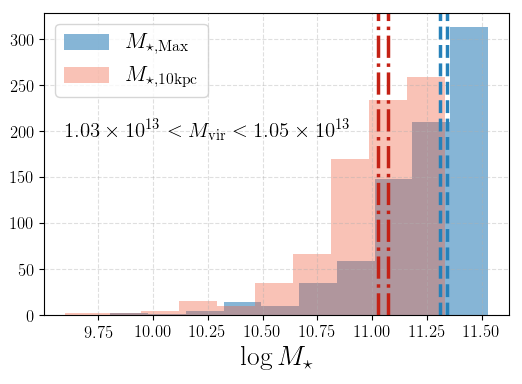

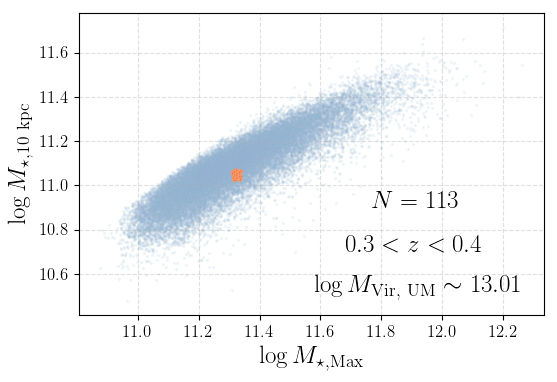

M10 is between 11.00 + (5/55 and 16/55 * 0.25)  
M10 is between 11.0227 and 11.0727   
round to 11.02 and 11.08  
11.05+-0.03  
(true values without rounding 11.0477+-0.025)


Mmax is between 11.25 + (12/55 and 20/55 * 0.25)  
Mmax is between 11.30 and 11.34  
11.32+-0.02

In [14]:
dm_Mmax=0.02
dm_M10=0.03

Mmax_mask = (hsc_table['logm_max'] > 11.3-dm_Mmax) & (hsc_table['logm_max'] < 11.3+dm_Mmax)
M10_mask = (hsc_table['logm_10'] > 11.05-dm_M10) & (hsc_table['logm_10'] < 11.05+dm_M10)
z_mask = (hsc_table['z_best'] > 0.3) & (hsc_table['z_best'] < 0.4)

dm_Mvir=0.1
Mvir_mask = (hsc_table['logm_vir'] > 13.02-dm_Mvir) & (hsc_table['logm_vir'] < 13.02+dm_Mvir)

2779 galaxies


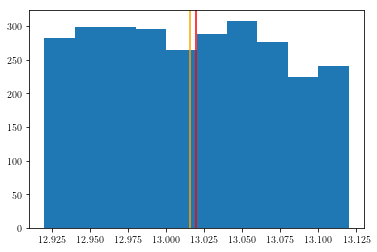

(array([  9.,  42., 108., 228., 344., 580., 775., 479., 180.,  34.]),
 array([10.62495249, 10.70420124, 10.78345   , 10.86269875, 10.9419475 ,
        11.02119625, 11.100445  , 11.17969375, 11.2589425 , 11.33819126,
        11.41744001]),
 <a list of 10 Patch objects>)

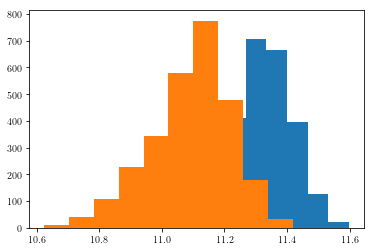

In [51]:
ponos_like_hsc_gals = hsc_table[np.all([Mvir_mask, z_mask], axis=0)]
print('{0} galaxies'.format(len(ponos_like_hsc_gals)))
plt.hist(ponos_like_hsc_gals['logm_vir'])
plt.axvline(13.02, c='r')
plt.axvline(np.median(ponos_like_hsc_gals['logm_vir']), c='orange')
plt.show()
plt.hist(ponos_like_hsc_gals['logm_100'])
plt.hist(ponos_like_hsc_gals['logm_10'])

266 galaxies


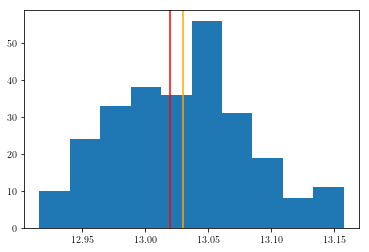

In [15]:
ponos_like_hsc_gals = hsc_table[np.all([M10_mask, Mmax_mask, z_mask], axis=0)]
print('{0} galaxies'.format(len(ponos_like_hsc_gals)))
plt.hist(ponos_like_hsc_gals['logm_vir'])
plt.axvline(13.02, c='r')
plt.axvline(np.median(ponos_like_hsc_gals['logm_vir']), c='orange')
plt.show()

In [80]:
ponos_like_hsc_gals_sbps = np.array(ponos_like_hsc_gals['sbp'])
ponos_like_hsc_gals_median_sbp = np.nanmedian(ponos_like_hsc_gals_sbps, axis=0)
ponos_like_hsc_gals_std_sbp = np.nanstd(ponos_like_hsc_gals_sbps, axis=0)

ponos_like_hsc_gals_cogs = np.array(ponos_like_hsc_gals['cog'])
ponos_like_hsc_gals_median_cog = np.nanmedian(ponos_like_hsc_gals_cogs, axis=0)
ponos_like_hsc_gals_std_cog = np.nanstd(ponos_like_hsc_gals_cogs, axis=0)

In [85]:
ponos_like_hsc_gals_std_sbp

array([0.22820031, 0.22811756, 0.22803485, 0.22795219, 0.22786957,
       0.227787  , 0.22770447, 0.22762198, 0.22753954, 0.22745715,
       0.2273748 , 0.22729249, 0.22721023, 0.22712801, 0.22704584,
       0.22696371, 0.22688163, 0.22679959, 0.2267176 , 0.22663565,
       0.22655375, 0.22647189, 0.22639008, 0.22630831, 0.22622659,
       0.22614491, 0.22606328, 0.22598169, 0.22590015, 0.22581866,
       0.22573721, 0.2256558 , 0.22557444, 0.22549313, 0.22541186,
       0.22533064, 0.22524946, 0.22516833, 0.22508725, 0.22500182,
       0.22487245, 0.22465394, 0.22435828, 0.22400873, 0.22362787,
       0.22323485, 0.22282579, 0.22240287, 0.22196276, 0.22150724,
       0.22103521, 0.22054473, 0.22003829, 0.21951009, 0.21895526,
       0.21836197, 0.21771015, 0.21699202, 0.21619769, 0.21531339,
       0.21435859, 0.21332094, 0.21219904, 0.21101198, 0.20974533,
       0.20840518, 0.20700866, 0.20553796, 0.20399889, 0.20240324,
       0.20073842, 0.19899891, 0.1972115 , 0.19537278, 0.19347

# Illustris and TNG

In [18]:
def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)
    pkl.close()  
    return array

#open pickels
tng_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_highres.pkl'
tng_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/tng_isos_merged.pkl'

illustris_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_masses_highres.pkl'
illustris_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/illustris_isos_merged.pkl'


tng_masses = open_pkl(tng_masses_file)
tng_isos = open_pkl(tng_isos_file)

illustris_masses = open_pkl(illustris_masses_file)
illustris_isos = open_pkl(illustris_isos_file)

In [70]:
dm=0.1
mass_def = 'm_tophat200'

ponos_like_tng_isos = [iso for iso, mass in zip(tng_isos, tng_masses[mass_def]) if (mass > 13.02-dm) & (mass < 13.02+dm)]
ponos_like_illustris_isos = [iso for iso, mass in zip(illustris_isos, illustris_masses[mass_def]) if (mass > 13.02-dm) & (mass < 13.02+dm)]

ponos_like_tng_masses = [mass['m_1d_100'] for mass in tng_masses if (mass[mass_def] > 13.02-dm) & (mass['m_tophat200'] < 13.02+dm)]
ponos_like_illustris_masses = [mass['m_1d_100'] for mass in illustris_masses if (mass[mass_def] > 13.02-dm) & (mass['m_tophat200'] < 13.02+dm)]



In [71]:
mean_tng_m100 = round(np.mean(ponos_like_tng_masses),2)
mean_illustris_m100 = round(np.mean(ponos_like_illustris_masses),2)

print(mean_tng_m100)
print(mean_illustris_m100)

11.28
11.42


In [72]:
radial_bins = np.arange(0.01, 3.5, 0.05)

In [73]:
V_mu = interp1d((V_iso['sma_kpc']) ** 0.25,
                 np.log10(V_iso['intens_kpc'] ),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(radial_bins)
SB_mu=interp1d((SB_iso['sma_kpc']) ** 0.25,
                 np.log10(SB_iso['intens_kpc']),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(radial_bins)

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:75: RuntimeWarning: divide by zero encountered in log10


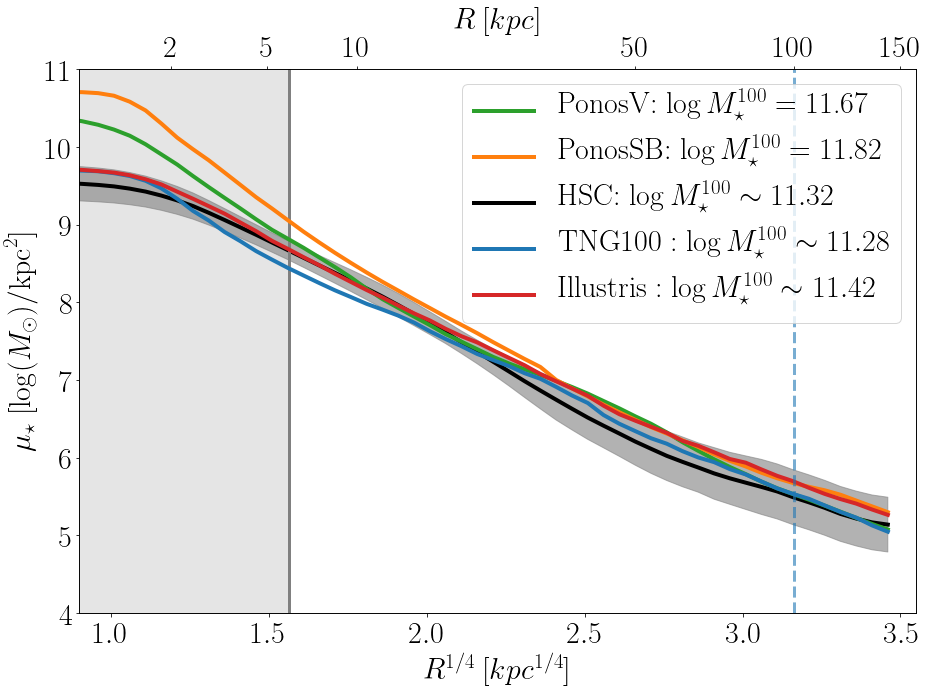

In [94]:
#mass range1
illustris_isos1=[]
ngals1=0

#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()

######################################################################################################################
# plot
######################################################################################################################
# for iso in illustris_top_isos:   
    
#         illustris_isos1.append(iso)

#         ax1.plot((iso['sma'] * pixel_scale) ** 0.25,
#              np.log10(iso['intens'] / (pixel_scale**2.0))+ np.log10(0.7 ** 2.0) , linewidth=1.0, c=u'#d62728', alpha=0.2, 
#                  label='_nolegend_')
#                  #label='Illustris Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))

ax1.plot(radial_bins, V_mu, linewidth=4.0, alpha=1, 
         label=r'PonosV: $\log M_{\star}^{100}=$ '+str(round(V_masses[3],2)),
         #label=r'PonosV: $ \log M_{vir} = 13.02; \log M_{\star}$ = '+str(round(V_masses[3],2)),
            c='#2ca02c')
ax1.plot(radial_bins, SB_mu, linewidth=4.0, alpha=1, 
         label=r'PonosSB: $\log M_{\star}^{100}=$  '+str(round(SB_masses[3],2)),
         #label=r'PonosSB: $ \log M_{vir} = 13.02; \log M_{\star}$ = '+str(round(SB_masses[3],2)),
         c='#ff7f0e')
# ax1.plot((Q_iso['sma'] * pixel_scale) ** 0.25,
#      np.log10(Q_iso['intens'] / (pixel_scale**2.0))+ np.log10(0.7 ** 2.0) , linewidth=4.0, alpha=1, 
#          label=r'PonosQ: $ M_{halo} = 12.77; M_{\star}$ = '+str(Q_masses[0]))


## median profiles for illustris
# median_sma1, median_mu1 = get_median_profile(illustris_isos1, pixel_scale = pixel_scale)
# ax1.plot(median_sma1, median_mu1+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#d62728', alpha=1, label='Illustris')

#hsc
hsc_median_sbp_interpolated = interp1d(sma_hsc, ponos_like_hsc_gals_median_sbp,
                                       fill_value="extrapolate")(radial_bins)
hsc_std_sbp_interpolated = interp1d(sma_hsc[~np.isnan(ponos_like_hsc_gals_std_sbp)],
                                    ponos_like_hsc_gals_std_sbp[~np.isnan(ponos_like_hsc_gals_std_sbp)],
                                    fill_value="extrapolate")(radial_bins)

plt.plot(radial_bins, hsc_median_sbp_interpolated,
         linestyle='-', linewidth=4.0, c='k',
         alpha=1, zorder=1,
         label='HSC: $\log M_{\star}^{100} \sim 11.32$')
plt.fill_between(radial_bins,
                 hsc_median_sbp_interpolated-hsc_std_sbp_interpolated,
                 hsc_median_sbp_interpolated+hsc_std_sbp_interpolated,
                 color='gray', alpha=0.6, zorder=1)

# for profile in ponos_like_hsc_gals_sbps:
#     plt.plot(radial_bins, interp1d(sma_hsc,profile,bounds_error=False, fill_value=np.nan,
#                                    kind='slinear')(radial_bins),
#           linestyle='-', linewidth=0.5, c='grey',
#          alpha=0.6, zorder=1, label=None)

#illustris and tng
median_tng = get_median_profile(ponos_like_tng_isos,1, radial_bins, quantity='intens_kpc')       
median_illustris = get_median_profile(ponos_like_illustris_isos,1, radial_bins, quantity='intens_kpc')  

std_tng = np.nanstd(np.stack([interp1d((gal['sma_kpc']) ** 0.25, 
                                               np.log10(gal['intens_kpc']),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(radial_bins) 
                               for gal in ponos_like_tng_isos]), axis=0)       
std_illustris = np.nanstd(np.stack([interp1d((gal['sma_kpc']) ** 0.25, 
                                               np.log10(gal['intens_kpc']),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(radial_bins) 
                               for gal in ponos_like_illustris_isos]), axis=0) 

ax1.plot(radial_bins,
     median_tng , linewidth=4.0, alpha=1, color=tng_color,
         label = r'$\mathrm{{TNG}}100: \log M_{{\star}}^{{100}}\sim{0}$'.format(mean_tng_m100))
#          label='TNG100: $\log M_{{vir}}\sim 13.02; \log M_{{\star}}^{{100}} \sim {0}$ '.format(mean_tng_m100)) 
# plt.fill_between(radial_bins,median_tng-std_tng,median_tng+std_tng, alpha=0.25, color=tng_color)
ax1.plot(radial_bins,
     median_illustris , linewidth=4.0, alpha=1, color=illustris_color,
         label = r'$\mathrm{{Illustris}}: \log M_{{\star}}^{{100}}\sim{0}$'.format(mean_illustris_m100))
# plt.fill_between(radial_bins,median_illustris-std_illustris,median_illustris+std_illustris, alpha=0.25,
#                  color=illustris_color)

#SDSS galaxies
# ax1.plot(patel10_mprof['rkpc'] ** 0.23, patel10_mprof['z0'] + 0.25, linewidth=4.0, alpha=0.75, c='k', linestyle=':',
#             label='$\mathrm{Patel+2013};\ z \sim 0.06$')
# ax1.plot(patel10_mprof['rkpc'] ** 0.23, patel10_mprof['z0'] + 0.40, linewidth=4.0, alpha=0.75, c='k', linestyle=':',
#             label='_no_label_')

######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim(0.9, 3.55)
ax1.set_ylim(4, 11)

ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
# ax1.text(1.8, 4.5, r'$n = $ {:01.2E} Mpc$^{{-3}}$'.format(hsc_n), size=30)

ax1.legend(fontsize=30)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 150**0.25])
ax1_twin.xaxis.set_ticklabels(["$2$", "$5$", "$10$", "$50$", "$100$", "$150$"])
ax1_twin.tick_params(axis='both', which='major', labelsize=30)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=30)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=1, c='grey', zorder=1)
ax1.fill_between([0,6.0 ** 0.25],[4,4], [11,11], color='grey', alpha =0.2)

######################################################################################################################

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/ponos_hsc.pdf',
            dpi=100, format='pdf', bbox_inches='tight')

plt.show()

## Cumulative

In [24]:
#DM softening lengths in kpc

ponos_softening = 0.785
illustris_softening = 1.4
tng_softening = 0.74

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log10


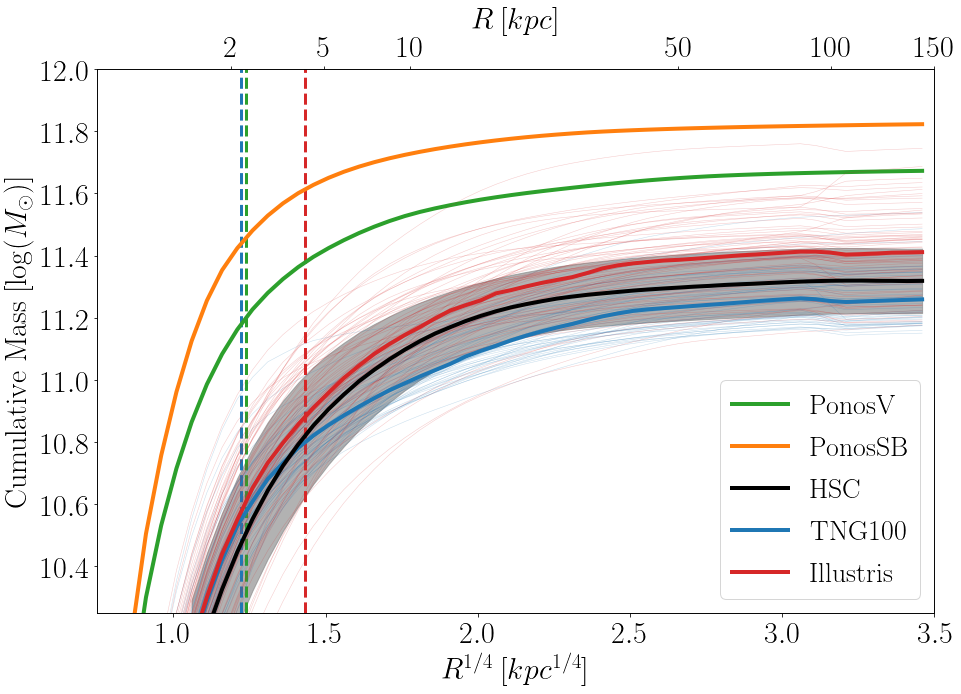

In [79]:
#mass range1
illustris_isos1=[]
ngals1=0

#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()

radial_bins = np.arange(0.01, 3.5, 0.05)
 ######################################################################################################################
# plot
######################################################################################################################

ax1.plot(radial_bins, 
         interp1d((V_iso['sma_kpc']) ** 0.25, np.log10(V_iso['growth_ori']) )(radial_bins),
         linewidth=4.0, alpha=1, c='#2ca02c',
         label = r'$\mathrm{PonosV}$') 
#          label=r'PonosV: $ \log M_{vir} = 13.02; \log M_{\star}$ = '+str(round(V_masses[3],2)))
ax1.plot(radial_bins, 
         interp1d((SB_iso['sma_kpc']) ** 0.25, np.log10(SB_iso['growth_ori']) )(radial_bins),
         linewidth=4.0, alpha=1, c='#ff7f0e',
         label = r'$\mathrm{PonosSB}$') 
#          label=r'PonosSB: $ \log M_{vir} = 13.02; \log M_{\star}$ = '+str(round(SB_masses[3],2))) 


#hsc
hsc_median_cog_interpolated = interp1d(sma_hsc, ponos_like_hsc_gals_median_cog, fill_value="extrapolate")(radial_bins)
hsc_std_cog_interpolated = interp1d(sma_hsc, ponos_like_hsc_gals_std_cog, fill_value="extrapolate")(radial_bins)

plt.plot(radial_bins, hsc_median_cog_interpolated,
         linestyle='-', linewidth=4.0, c='k',
         alpha=1, zorder=8,
         label = r'$\mathrm{HSC}$')
plt.fill_between(radial_bins,hsc_median_cog_interpolated-hsc_std_cog_interpolated,
                 hsc_median_cog_interpolated+hsc_std_cog_interpolated,
                 color='gray', alpha=0.6, zorder=1)
# for profile in ponos_like_hsc_gals_cogs:
#     plt.plot(radial_bins, 
#              interp1d(sma_hsc,profile, fill_value="extrapolate")(radial_bins),
#              linestyle='--', linewidth=0.5, c='grey',
#          alpha=0.3, zorder=1, label=None)
    

for tng_iso in ponos_like_tng_isos:
    ax1.plot(radial_bins,
         interp1d((tng_iso['sma_kpc']) ** 0.25,np.log10(tng_iso['growth_ori']) )(radial_bins),
             linewidth=0.5, alpha=0.25, color =tng_color, label='_nolegend_' )
for illustris_iso in ponos_like_illustris_isos:
    if np.log10(illustris_iso['growth_ori'])[3] > 8: #ignore 1 weird profile
        ax1.plot(radial_bins,
         interp1d((illustris_iso['sma_kpc']) ** 0.25, np.log10(illustris_iso['growth_ori']) )(radial_bins),
                 linewidth=0.5, alpha=0.25, color =illustris_color,
                 label='_nolegend_' )

median_tng = get_median_profile(ponos_like_tng_isos,1, radial_bins, quantity='growth_ori')       
median_illustris = get_median_profile(ponos_like_illustris_isos,1, radial_bins, quantity='growth_ori')  

ax1.plot(radial_bins,
     median_tng , linewidth=4.0, alpha=1, color=tng_color,
         label = r'$\mathrm{TNG}100$')
#          label='TNG100: $\log M_{{vir}}\sim 13.02; \log M_{{\star}} \sim {0}$ '.format(mean_tng_m100)) 
ax1.plot(radial_bins,
     median_illustris , linewidth=4.0, alpha=1, color=illustris_color,
         label = r'$\mathrm{Illustris}$')
#          label='Illustris: $\log M_{{vir}}\sim 13.02; \log M_{{\star}} \sim {0}$ '.format(mean_illustris_m100) )
######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim(0.75, 3.5)
ax1.set_ylim(10.25, 12)

ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
# ax1.text(1.8, 4.5, r'$n = $ {:01.2E} Mpc$^{{-3}}$'.format(hsc_n), size=30)

ax1.legend(fontsize=28)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 150**0.25])
ax1_twin.xaxis.set_ticklabels(["$2$", "$5$", "$10$", "$50$", "$100$", "$150$"])
ax1_twin.tick_params(axis='both', which='major', labelsize=30)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=30)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'Cumulative Mass $[\log(M_{\odot}) ]$', fontsize=30)
# ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
# ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=1, c='grey', zorder=1)
# ax1.fill_between([0,6.0 ** 0.25],[4,4], [13,13], color='grey', alpha =0.2)

ax1.axvline((ponos_softening*3) ** 0.25, linestyle='--', linewidth=3.0, alpha=1, c='#2ca02c', zorder=1)
ax1.axvline((tng_softening*3) ** 0.25, linestyle='--', linewidth=3.0, alpha=1, c=tng_color, zorder=1)
ax1.axvline((illustris_softening*3) ** 0.25, linestyle='--', linewidth=3.0, alpha=1, c=illustris_color, zorder=1)
# ax1.axvline(2.1 ** 0.25, linestyle=':', linewidth=3.0, alpha=1, c=illustris_color, zorder=1)
######################################################################################################################

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/cumulative_mass_profile.pdf',
            dpi=100, format='pdf', bbox_inches='tight')

plt.show()

## check mass offsets between HSC and Ponos

In [62]:
HSC_mean_masses = interp1d(sma_hsc**4, ponos_like_hsc_gals_median_cog, fill_value="extrapolate")([10,30,100])
HSC_mean_masses = append_outer_mass(HSC_mean_masses)
HSC_mean_masses

array([11.106991 , 11.27198  , 11.3190043, 10.3302423])

In [63]:
HSC_masses = []
for profile in ponos_like_hsc_gals_cogs:
    gal_array = interp1d(sma_hsc**4,profile, fill_value="extrapolate")([10,30,100])
    gal_array = append_outer_mass(gal_array)
    HSC_masses.append(10**gal_array)
    
hsc_mass_stds = np.nanstd(HSC_masses, axis=0)
print(hsc_mass_stds)
log_hsc_mass_stds = np.nanstd(np.log10(HSC_masses), axis=0)
print(log_hsc_mass_stds)

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


[3.58440941e+10 4.42516286e+10 4.90476356e+10 9.94601007e+09]
[0.12827692 0.10380516 0.10549349 0.28612946]


In [98]:
PonosV_masses = interp1d((V_iso['sma_kpc']),np.log10(V_iso['growth_ori']), fill_value="extrapolate" )([10,30,100])
PonosSB_masses = interp1d((SB_iso['sma_kpc']),np.log10(SB_iso['growth_ori']), fill_value="extrapolate" )([10,30,100])

PonosV_masses, PonosSB_masses = append_outer_mass(PonosV_masses), append_outer_mass(PonosSB_masses)

print('PonosV_masses: M10 = {0}, M30 = {1}, M100 = {2}'.format(PonosV_masses[0], PonosV_masses[1], PonosV_masses[2]))
print('PonosSB_masses: M10 = {0}, M30 = {1}, M100 = {2}'.format(PonosSB_masses[0], PonosSB_masses[1], PonosSB_masses[2]))


PonosV_masses: M10 = 11.5323405096, M30 = 11.6215749022, M100 = 11.6677998216
PonosSB_masses: M10 = 11.7279761131, M30 = 11.7952802559, M100 = 11.818885716


/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


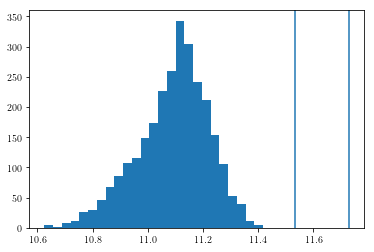

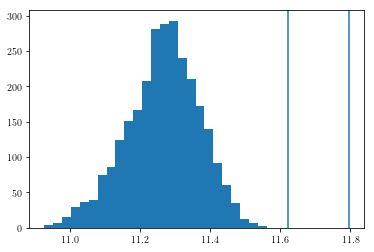

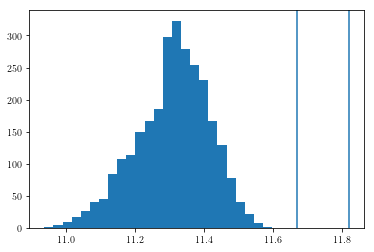

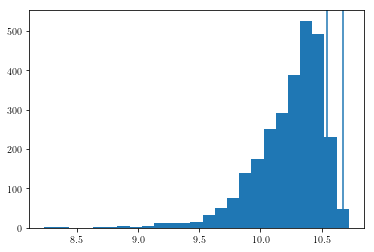

In [65]:
arr_10 = [np.log10(mass[0]) for mass in HSC_masses]
arr_30 = [np.log10(mass[1]) for mass in HSC_masses]
arr_100 = [np.log10(mass[2]) for mass in HSC_masses]
arr_outer = [np.log10(mass[3]) for mass in HSC_masses]

plt.hist(np.array(arr_10)[~np.isnan(arr_10)], bins=25)
plt.axvline(PonosV_masses[0])
plt.axvline(PonosSB_masses[0])
plt.show()

plt.hist(np.array(arr_30)[~np.isnan(arr_30)], bins=25)
plt.axvline(PonosV_masses[1])
plt.axvline(PonosSB_masses[1])
plt.show()

plt.hist(np.array(arr_100)[~np.isnan(arr_100)], bins=25)
plt.axvline(PonosV_masses[2])
plt.axvline(PonosSB_masses[2])
plt.show()

plt.hist(np.array(arr_outer)[~np.isnan(arr_outer)], bins=25)
plt.axvline(PonosV_masses[3])
plt.axvline(PonosSB_masses[3])
plt.show()


In [66]:
hsc_mass_stds

array([3.58440941e+10, 4.42516286e+10, 4.90476356e+10, 9.94601007e+09])

In [99]:
#mass difference in terms of stds
stds_PonosV = ((10**PonosV_masses) - (10**HSC_mean_masses))/(hsc_mass_stds)
pp_PonosV = st.norm.cdf(stds_PonosV)
print('real space: ', stds_PonosV, pp_PonosV)

log_stds_PonosV = ((PonosV_masses) - (HSC_mean_masses))/(log_hsc_mass_stds)
log_pp_PonosV = st.norm.cdf(log_stds_PonosV)
print('log space: ',log_stds_PonosV, log_pp_PonosV)

('real space: ', array([5.93513994, 5.22747404, 5.2381809 , 2.57350921]), array([1.        , 0.99999991, 0.99999992, 0.99496635]))
('log space: ', array([3.31586933, 3.36779871, 3.30632257, 1.19436111]), array([0.99954321, 0.99962115, 0.99952735, 0.88383163]))


In [100]:
#mass difference in terms of stds
stds_PonosSB = ((10**PonosSB_masses) - (10**HSC_mean_masses))/(hsc_mass_stds)
pp_PonosSB = st.norm.cdf(stds_PonosSB)
print('real space: ',stds_PonosSB, pp_PonosSB)

log_stds_PonosSB = ((PonosSB_masses) - (HSC_mean_masses))/(log_hsc_mass_stds)
log_pp_PonosSB = st.norm.cdf(log_stds_PonosSB)
print('log space: ',log_stds_PonosSB, log_pp_PonosSB)

('real space: ', array([11.34355577,  9.87710244,  9.18595358,  1.35445623]), array([1.        , 1.        , 1.        , 0.91220456]))
('log space: ', array([4.84097298, 5.04117744, 4.73850469, 0.7413508 ]), array([0.99999935, 0.99999977, 0.99999892, 0.77075961]))


In [69]:
print('PonosV mass differences in dex: ', PonosV_masses - HSC_mean_masses)
print('PonosSB mass differences in dex: ', PonosSB_masses - HSC_mean_masses)

('PonosV mass differences in dex: ', array([0.42534951, 0.3495949 , 0.34879552, 0.34174189]))
('PonosSB mass differences in dex: ', array([0.62098512, 0.52330025, 0.49988141, 0.2121223 ]))


quoting differences in real space in the paper

big change from before: decided to use Mvir from new catalog (after Song fixed bug in stellar mass profiles). I calculated Mvir from the relation in paper. Then used a cut in Mvir (rather than a cut in Mmax and M10 as Song was doing before) to select Ponos-like HSC comparison sample.

also fixed Ponos mass calculation and profiles which were all off by a pixel scale factor^2.